In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
from scipy.stats import gaussian_kde

In [2]:
import point_cloud_registration as pcr

In [3]:
points1 = np.load('data/Animal1_Day1_points.npy')
points2 = np.load('data/Animal1_Day2_points.npy')

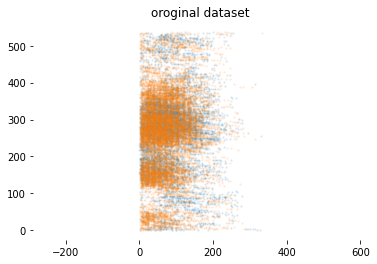

In [4]:
plt.scatter(*points1[:,:2].T, s=2, alpha=0.1)
plt.scatter(*points2[:,:2].T, s=2, alpha=0.1)
plt.axis('equal')
plt.box(False)
plt.title('oroginal dataset');

In [5]:
# crop and scale datasets differently
points1 = points1[points1[:,1] < 0.6*points1[:,1].max(), :]
points1 *= 1.5
points2 = points2[points2[:,0] < 0.8*points2[:,0].max(),:]

# rotate and translate the second set
alpha = 0.1
rotation = [
    [np.cos(alpha), -np.sin(alpha), 0],
    [np.sin(alpha), np.cos(alpha), 0],
    [0, 0, 1]]
points2 = points2 @ rotation + np.array([500, -100, 30])


Text(0.5, 1.0, 'transformed datasets')

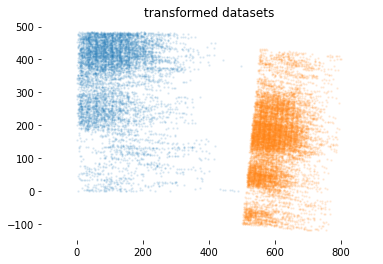

In [6]:
plt.scatter(*points1[:,:2].T, s=2, alpha=0.1)
plt.scatter(*points2[:,:2].T, s=2, alpha=0.1)
plt.axis('equal')
plt.box(False)
plt.title('transformed datasets')

In [7]:
tetras1 = pcr.make_normal_tetras(points1)
tetras2 = pcr.make_normal_tetras(points2)

In [ ]:
pcr.compute_canonical_features(tetras1)

computing tetra features:   9%|████▍                                           | 3102/33889 [00:16<02:43, 187.85it/s]

In [ ]:
pcr.remove_common_tetras(tetras1)

In [ ]:
pcr.compute_canonical_features(tetras2)
pcr.remove_common_tetras(tetras2)

In [ ]:
tetras1['vertices'].shape

In [ ]:
F1 = tetras1['features']
F2 = tetras2['features']

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].scatter(*F1[:,[0,1]].T, s=1, alpha=0.2)
ax[0].scatter(*F2[:,[0,1]].T, s=1, alpha=0.2)

ax[1].scatter(*F1[:,[2,3]].T, s=1, alpha=0.2)
ax[1].scatter(*F2[:,[2,3]].T, s=1, alpha=0.2)

ax[2].scatter(*F1[:,[4,5]].T, s=1, alpha=0.2)
ax[2].scatter(*F2[:,[4,5]].T, s=1, alpha=0.2)

fig.suptitle('feature space')

In [ ]:
distances, matches = pcr.match_features(tetras1, tetras2)

In [ ]:
ix = ~np.isinf(distances)
distances = distances[ix]
matches = np.stack(matches[ix])[:,0]
pcr.select_tetras(tetras2, ix)

In [ ]:
# vote based on norms
N1 = tetras1['norms']
N2 = tetras2['norms']

nn = np.stack([N2[:,0,0], N1[matches][:,0,0]]).T
density = gaussian_kde(nn.T)(nn.T)
plt.scatter(*nn.T, c=density, s=8, alpha=0.2)
n1, n2 = nn[np.argmax(density)]
plt.plot(n1, n2, 'kx')
plt.grid(True)
plt.box(False)
n2 / n1

In [ ]:
# remove matches with other scales
ix = (nn[:,0]/n1 - 1) ** 2 + (nn[:,1]/n2 - 1) ** 2 < 0.05 ** 2
matches = matches[ix]
pcr.select_tetras(tetras2, ix)

In [ ]:
q, r = np.unique(matches, return_inverse=True)
matches = matches[r]
pcr.select_tetras(tetras2, r)
pcr.select_tetras(tetras1, matches)